In [1]:
from flipper import liteMap
import matplotlib.pyplot as plt
import numpy as np
from cactusLib import filterLib
from cactusLib.cactusUtils import saveFits
from flipper import fftTools
import scipy


/home/cvargas/.local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
#Marsden Area

RA0 = 3.
RA1 = 106.75
DEC0 = -56.2
DEC1 = -49.0


lt = liteMap.liteMapFromFits("/home/cvargas/data/act/act_depots/cactus_depots/20180419/ACT_220_south_season_2_1way_v3_srcfree.fits")

ltw = liteMap.liteMapFromFits("/home/cvargas/data/act/act_depots/cactus_depots/20180419/ACT_220_south_season_2_1way_hits_v3.fits")

lt = lt.selectSubMap(RA0,RA1,DEC0,DEC1)
ltw = ltw.selectSubMap(RA0,RA1,DEC0,DEC1)

lt.data = lt.data*np.sqrt(ltw.data)

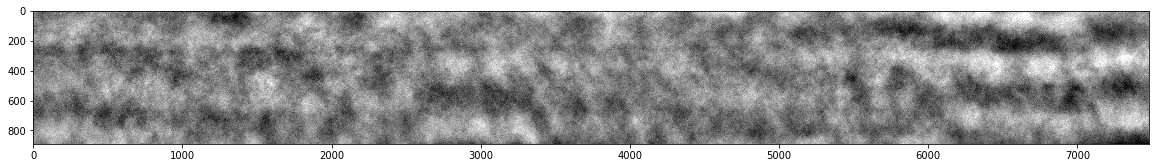

In [3]:
plt.figure(figsize=(20,15))
plt.imshow(lt.data,cmap="gray",vmin = -3e5, vmax= 3e5)
plt.show()

saveFits(lt.data/np.sqrt(ltw.data),"Original_noise.fits",lt.header)

In [4]:
lt_std = np.std(lt.data)
lt_std

88121.19930551681

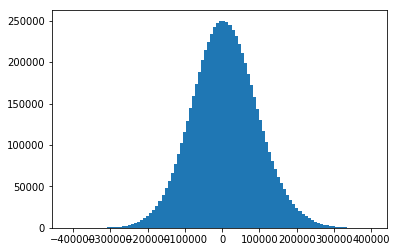

In [5]:
plt.hist(lt.data.flatten(),100)
plt.show()

In [6]:
def new_realization(lt,i): 
    #Getting new exponential from a random realization
    mu = 0.
    sigma = 1.
    Ny,Nx = lt.data.shape
    new = np.fft.fft2(np.random.normal(mu,sigma,(Ny,Nx)))
    new_exp = new/np.abs(new)
    #New fft
    #M_fft2 = a*new_exp
    #real part of ifft
    #M = np.real(np.fft.ifft2(M_fft2))
    
    #Making the power spectrum a bit softer #############################
    
    noiseMap = lt.copy()

    pad = 100
    extraYPad = 0
    apodNx,apodNy = noiseMap.data.shape
    apod = noiseMap.data.copy()
    apod[:] = 0.0
    apod[pad+extraYPad:apodNy-pad-extraYPad,pad:apodNx-pad] = 1.0
    N_apod = scipy.ndimage.gaussian_filter(apod,20,mode="constant")
    
    noiseMap.data *= N_apod
    
    FTNM = fftTools.fftFromLiteMap(noiseMap)
    
    a = np.abs(FTNM.kMap)
    
    #gFilterSigma = 5.
    
    #smooth = scipy.ndimage.gaussian_filter(np.fft.fftshift(a), gFilterSigma)
    
    #a = smooth
    #a = np.fft.ifftshift(a)

    #ellxMin = 100.
    #ellyMin = 0.
    #ellMin = 500.
    
    #lmask = np.ones(FTNM.modLMap.shape)
    #lmask[:, np.abs(FTNM.lx) < ellxMin] = 0.  # vertical strip
    #lmask[np.abs(FTNM.ly) < ellyMin] = 0.  # horizontal strip
    #lmask[FTNM.modLMap < ellMin] = 0.  # low-ell circle
    
    #a*=lmask
    
    ##################################################################
    M_fft2 = a*new_exp
    M_fft2 = filterLib.symmetrizeFFT(M_fft2)
    M = np.real(np.fft.ifft2(M_fft2))
    
    #plotting
    plt.figure(figsize=(20,15))
    plt.imshow(M,cmap="gray")
    #standard deviation
    M_std = np.std(M)
    
    f = lt_std/M_std
    
    M*= f
    
    saveFits(M/np.sqrt(ltw.data),"noise{}.fits".format(i),lt.header)
    print "Realization {}".format(i)
    print "M_std = {}".format(M_std)
    print "lt_std/M_std = {}".format(lt_std/M_std)
    #print "lt_std/M_std = {}".format(lt_std/np.std(M))    
    print " "
    #print f

Realization 0
M_std = 22272.0408123
lt_std/M_std = 3.95658395422
 
Realization 1
M_std = 22272.0408123
lt_std/M_std = 3.95658395422
 
Realization 2
M_std = 22272.0408123
lt_std/M_std = 3.95658395422
 
Realization 3
M_std = 22272.0408123
lt_std/M_std = 3.95658395422
 


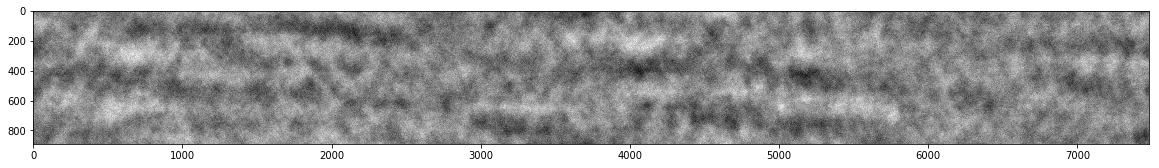

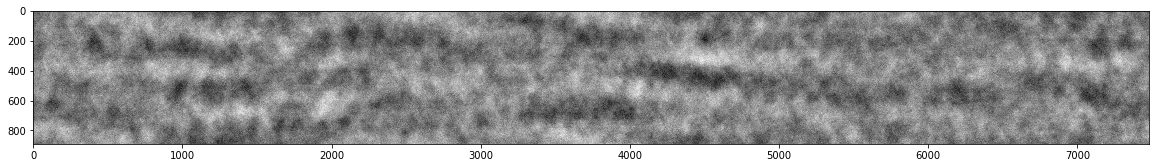

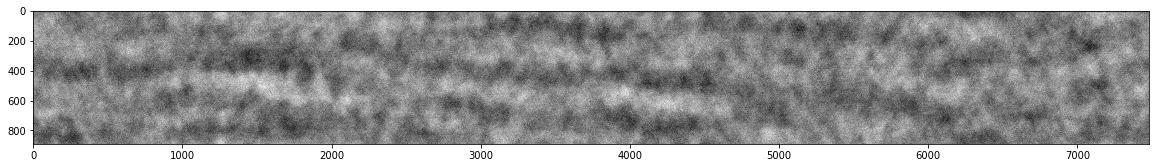

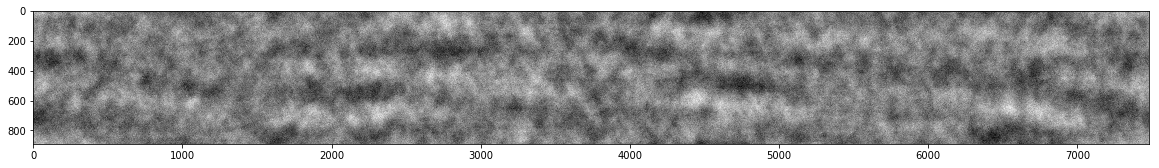

In [7]:
for i in range(4):
    new_realization(lt,i)